# Reinforcement learning from scratch: homework 1

## Andrew SaLoutos, April 30 2018

## EECS 495, Reinforcement Learning

## Homework 1 (completed iPython notebook)

### General instructions

Complete the exericse listed below in this Jupyter notebook - leaving all of your code in Python cells in the notebook itself.  Feel free to add any necessary cells.  

### When submitting this homework:

**Make sure you have put your name at the top of each file**
    
**Make sure all output is present in your notebook prior to submission**

In [6]:
# import custom libraries
from custom_library import basic_optimizers as optimizers
from custom_library import variable_order_plotters as plotter

# import autograd functionality
import autograd.numpy as np

# import path to datasets
datapath = 'datasets/'

# this is needed to compensate for %matplotl+ib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True
%matplotlib notebook

# autoreload function - so if anything behind the scenes is changeed those changes
# are reflected in the notebook without having to restart the kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### <span style="color:#a50e3e;">Exercise 1: </span>  Perform system identification on a small chunk of cruise control data 

In this exercise you will create a system model - denoted as $f_{\text{system}}$ in the [course notes](https://www.dropbox.com/s/m6456ze0fd8kaf8/system_identification_pid_notes.pdf?dl=0) - using a small snippet of cruise control data shown below.  Here our `output sequence` are states $\left\{s_t\right\}_{t=1}^T$, and the `input sequence` corresponding actions $\left\{a_t\right\}_{t=1}^{T-1}$ (we can ignore any finanl action $a_T$ since there is no next state $s_{t+1}$ to regress it on in learning our system model).  Notice at each update step the action is clipped to lie in the range $[-50,100]$ - which is the angle of the pedal against the floor of the car.  Here a negative angle indicates that 'regenerative braking' was applied.

<IPython.core.display.Javascript object>


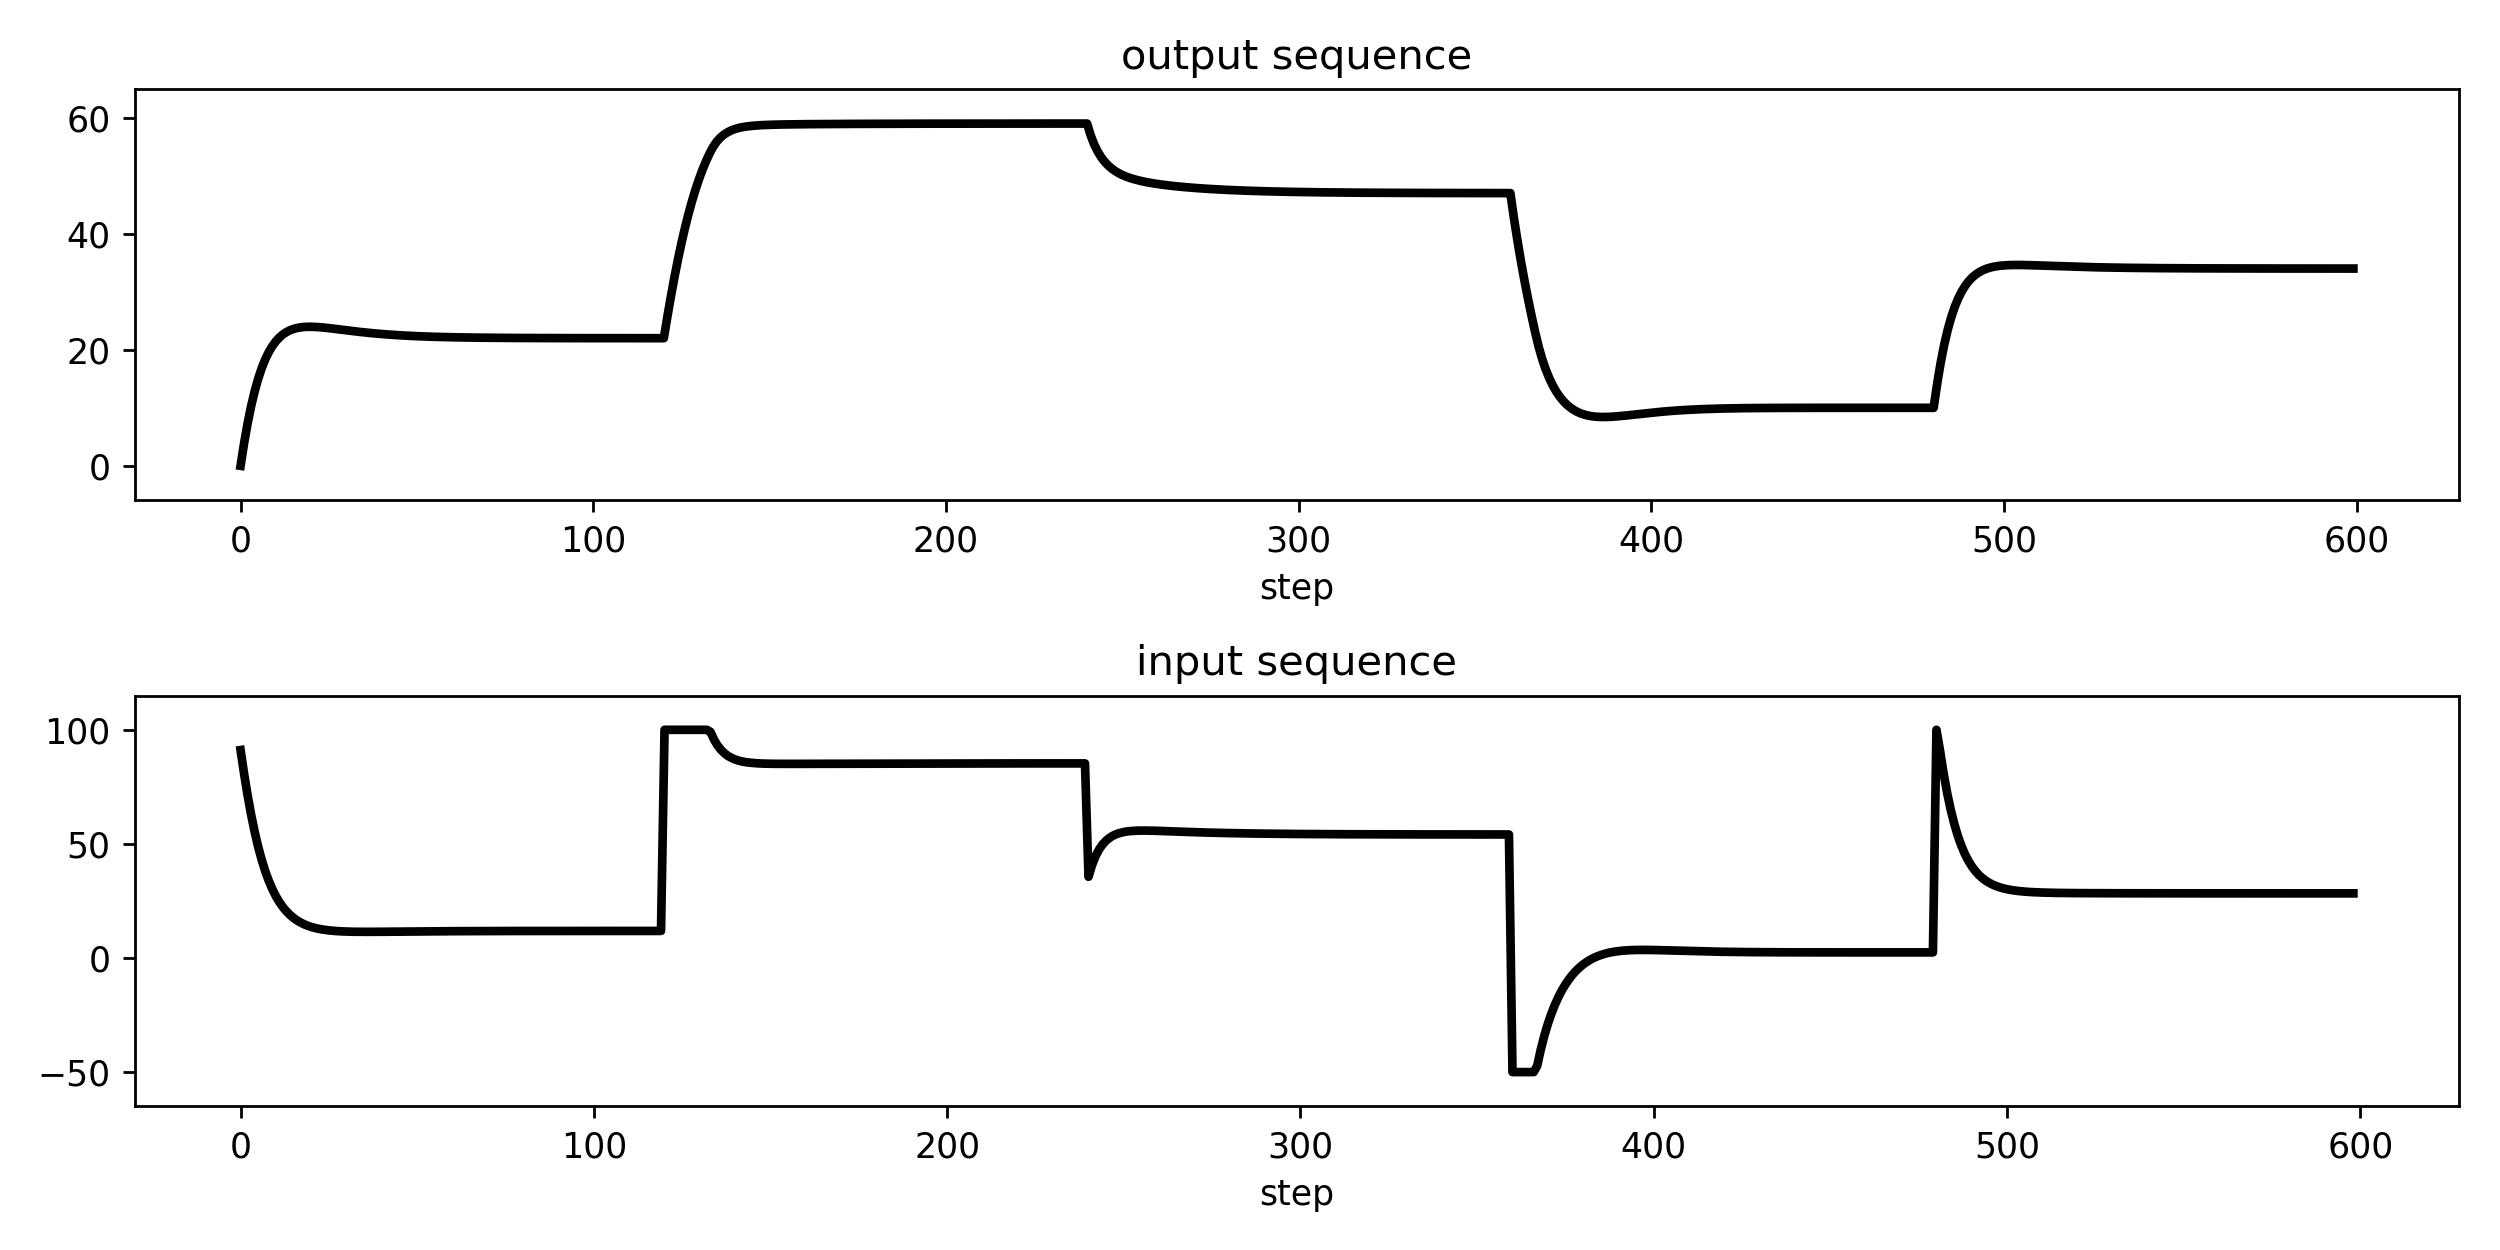

In [7]:
# load in cruise control data
data = np.loadtxt(datapath + 'cruise_control_data.csv',delimiter = ',')

# extract actions and states 
actions = data[0,1:][np.newaxis,:] # our T-1 actions
states = data[1,:][np.newaxis,:]   # our T states

# plot the test pair
plotter.plot_pair(actions,states)

Some more particulars: here you need to learn the weights of a basic order $1$ linear system model - which takes the form

\begin{equation}
s_{t+1} = f_{\text{system}}\left(s_t,a_t; \mathbf{w}_\text{system}\right) = w_0 + w_1s_t + w_2a_t
\end{equation}

by properly minimizing the associated Least Squares cost function

\begin{equation}
\frac{1}{T-1}\sum_{t=1}^{T-1}\left(f_{\text{system}}\left(s_t,a_t; \mathbf{w}_\text{system}\right) - s_{t+1}\right)^2
\end{equation}

over the weights $\mathbf{w}_{\text{system}} = \begin{bmatrix} w_0 \\ w_1 \\ w_2 \end{bmatrix}$ where $T$ is the length of our training action sequence.  


- Build a `Python` version of the system model and Least Squares cost function and minimize it using a first order method.  Use the entire dataset provided for training (i.e., do not worry about validation error)


- A simple full batch gradient descent module has been provided in file file `basic_optimizers.py` in the `custom_library` directory for use with this exercise.


- After properly minimizing the Least Squares cost above make a plot like the one shown below - which shows the original state data in black, and the system model approximation in blue.  Your trained model should be able to match the data quite well.

In [4]:
### system model

def g(w,a_train,s_train):
    ''' Least squares cost function '''
    
    J = 0
    
    T = s_train.shape[1]
    
    for ii in range(1,T-1):
        J = J + (w[0] + w[1]*s_train[0,ii] + w[2]*a_train[0,ii] - s_train[0,ii+1])**2
    
    J = J/(T-1)
    
    return J    

### minimize the least squares (using entire dataset) using full-batch gradient descent
weights = np.random.rand(3,1)

alpha = 0.00025
max_its = 100
verbose = True

w_hist,train_hist = optimizers.gradient_descent(g,weights,actions,states,alpha,max_its,verbose)

step 2 done in 0.4 secs, train cost = 274.3549
step 3 done in 0.3 secs, train cost = 228.9166
step 4 done in 0.3 secs, train cost = 191.2125
step 5 done in 0.3 secs, train cost = 159.8879
step 6 done in 0.4 secs, train cost = 133.8322
step 7 done in 0.3 secs, train cost = 112.1339
step 8 done in 0.4 secs, train cost = 94.0437
step 9 done in 0.4 secs, train cost = 78.9449
step 10 done in 0.4 secs, train cost = 66.3294
step 11 done in 0.3 secs, train cost = 55.7777
step 12 done in 0.4 secs, train cost = 46.9433
step 13 done in 0.4 secs, train cost = 39.5397
step 14 done in 0.4 secs, train cost = 33.3292
step 15 done in 0.4 secs, train cost = 28.1149
step 16 done in 0.3 secs, train cost = 23.7333
step 17 done in 0.4 secs, train cost = 20.0483
step 18 done in 0.4 secs, train cost = 16.9468
step 19 done in 0.4 secs, train cost = 14.3345
step 20 done in 0.4 secs, train cost = 12.1325
step 21 done in 0.4 secs, train cost = 10.2752
step 22 done in 0.4 secs, train cost = 8.7076
step 23 done in 

[[0.79099447]
 [0.9381812 ]
 [0.03688175]]


<IPython.core.display.Javascript object>


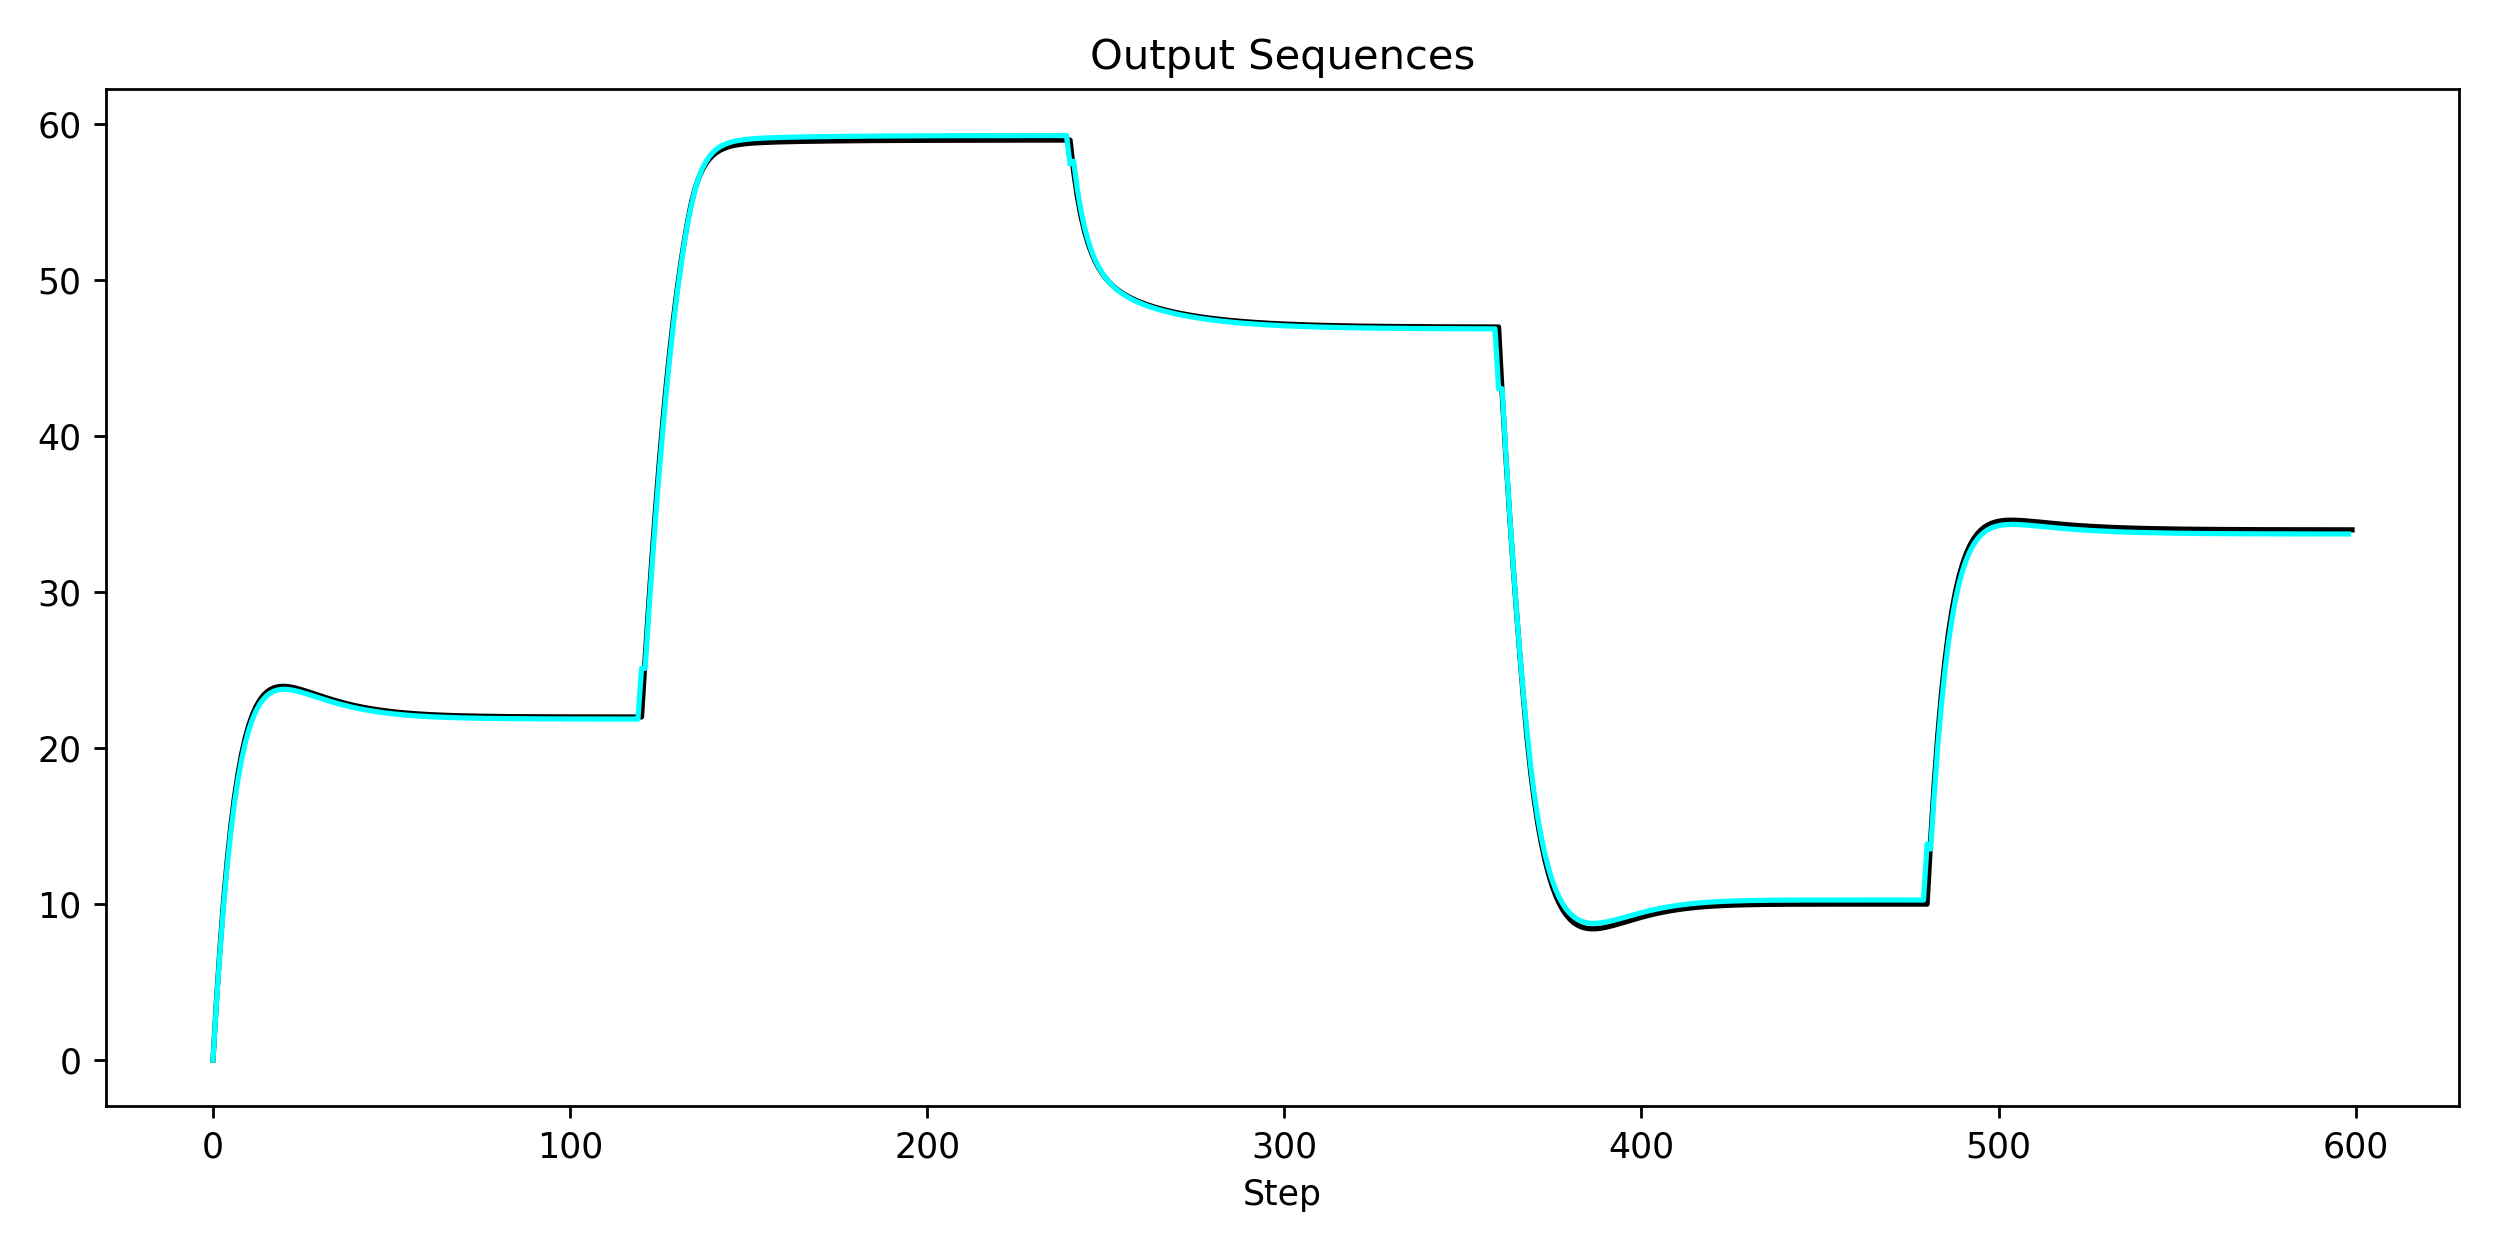

In [8]:
### plot original state data and system model approximation

# evaluate output of learned model
opt_weights = w_hist[-1]
print(opt_weights)    # cost of 0.0556; weights = [0.7749408, 0.9390561, 0.03648759]

T = states.shape[1]
system_model = np.zeros(T-1)
    
for ii in range(1,T-1):
    system_model[ii] = opt_weights[0] + opt_weights[1]*states[0,ii-1] + opt_weights[2]*actions[0,ii]


import matplotlib.pyplot as plt
from matplotlib import gridspec
import copy

# initialize figure
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(111); 

# plot data
ax1.plot(np.arange(np.size(system_model)),system_model.flatten(),c = 'cyan',linewidth = 1.5,label = 'System Model',zorder = 2)
ax1.plot(np.arange(np.size(states)),states.flatten(),c = 'black',linewidth = 1.5,label = 'Original States',zorder = 1)

# label axes and title
ax1.set_title('Output Sequences')
ax1.set_xlabel('Step')

plt.show()

#### <span style="color:#a50e3e;">Exercise 2: </span>  Train an unregularized PID controller for the cruise control problem

In this exercise you will tune the parameters of a PID controller automatically so that the system model trained in the previous exercise matches the example set point sequence shown below.  Note: you need to have finished the previous exercise in order to properly solve this one!

<IPython.core.display.Javascript object>


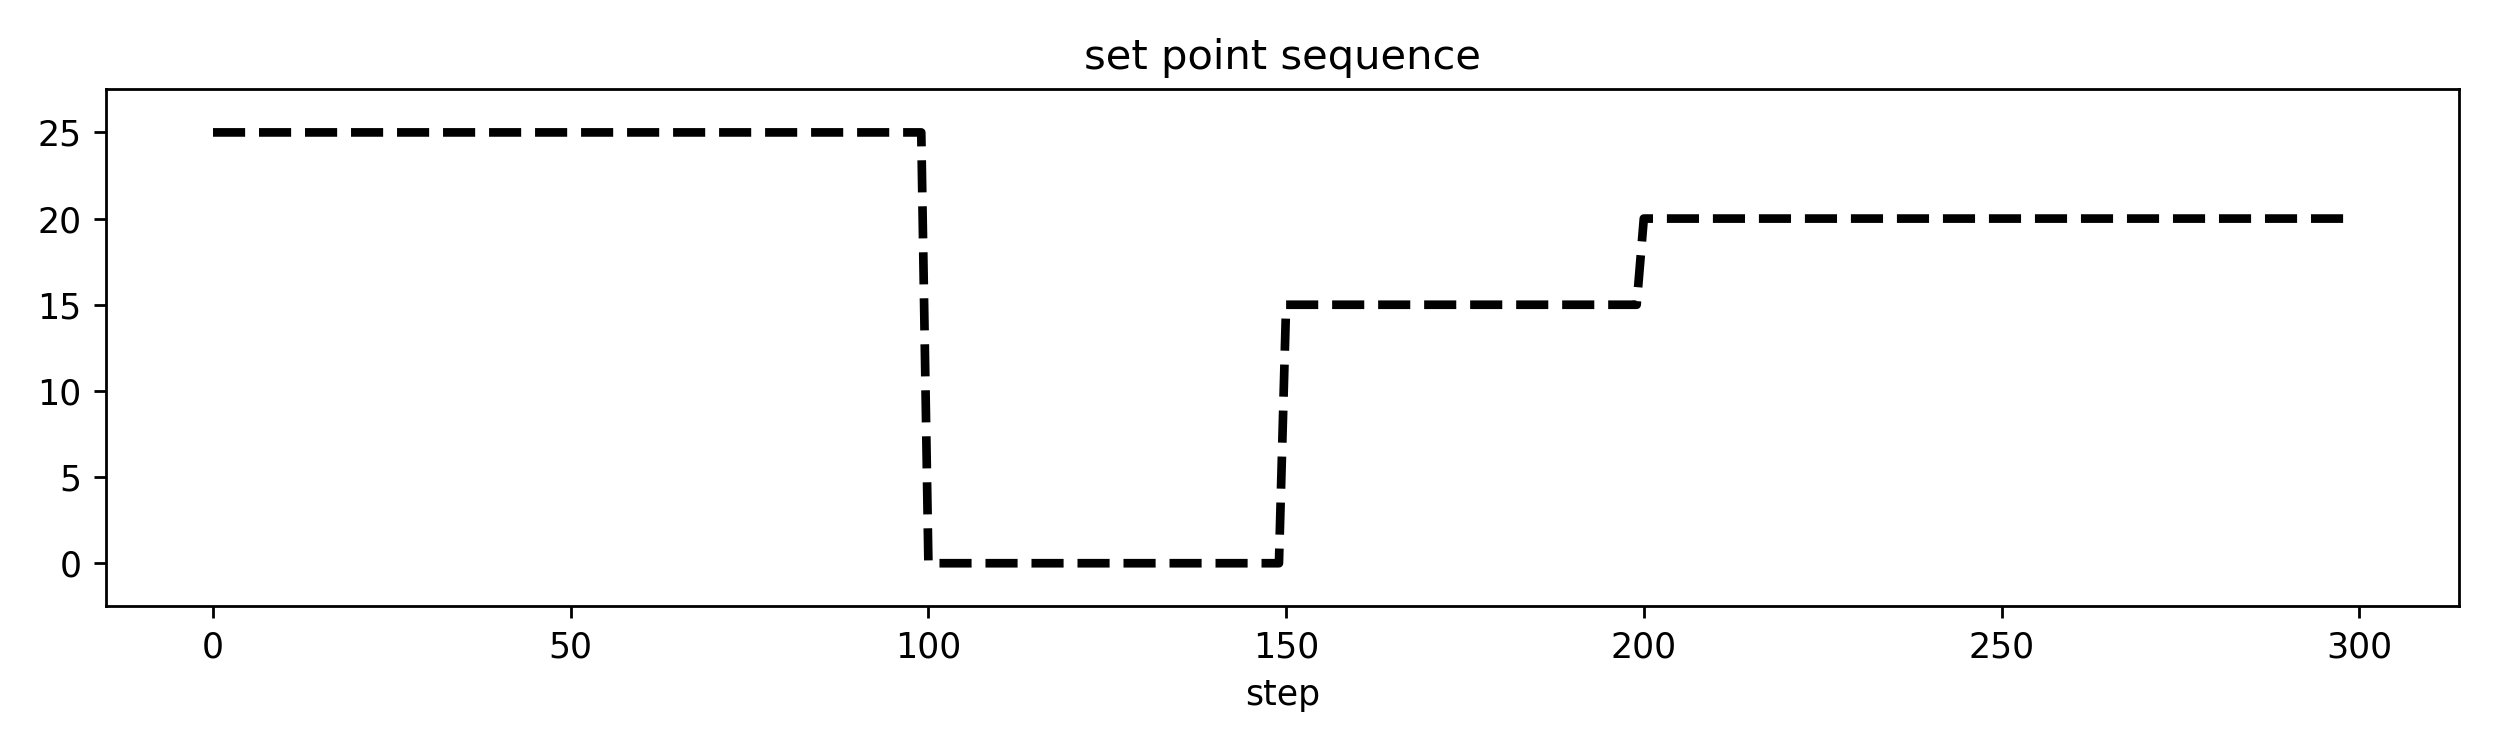

In [9]:
# load in set point sequence
csvname = 'datasets/cruise_setpoints.csv'
set_points = np.loadtxt(csvname,delimiter = ',')[np.newaxis,:]

# plot set point sequence
plotter.plot_setpoints(set_points)

Implement a `Pythonic` version of the PID controller Least Squares cost function discussed in the [course notes](https://www.dropbox.com/s/m6456ze0fd8kaf8/system_identification_pid_notes.pdf?dl=0).  You should be able to learn an action / state sequence pair so that your system model responds fairly well to the input set point sequence.  The image below shows the results of an action/state sequence pair learned by a fully tuned PID controller.  The top panel shows the set point sequence in dashed black, with the state sequence defined by the controller in blue.  The bottom panel shows the corresponding action sequence defined by the controller. 

A few notes: 
- For this exercise you need not worry about regularizing either the state or action sequences when training the controller - simply tune it as best as you can.


- Even though a PID controller is technically a Recurrent Network (which can be slow to train), here we only deal with a fairly small dataset of set points and there only 4 parameters to tune - so you can apply the simplest kind of first order algorithm to properly minimize the controller cost (e.g., a full batch gradient descent optimizer). 

<figure>
<p>
<img src= 'images/PID_1.png' width="150%" height="150%" alt=""/>
</p>
</figure>

In [42]:
# inner loop gradient descent function to tune weights

V = [0.7749408, 0.9390561, 0.03648759] # optimal weights for system model, from problem 1


def g(w,a_train,s_train):
    ''' 
    Least squares cost function 

    Incorporating PID weights into system model

    '''
    
    J = 0
    T = set_points.shape[1]
    dt = 1 # time is given in "steps"
    
    Perror = 0
    Ierror = 0
    Derror = 0
    last_error = 0
    
    reg = 0.1
    TV = 0
    
    action = 0
    state = 0    
    last_action = 0
    last_state = 0
    
    for ii in range(1,T-1):
        
        Perror = s_train[0,ii] - last_state
        Ierror = Ierror + (dt)*Perror
        Derror = (Perror - last_error) / dt
        
        action = w[0] + w[1]*Perror + w[2]*Ierror + w[3]*Derror # current action from PID controller
        if (action>100.0):
            action = 100.0
        if (action<-50.0):
            action = -50.0
        state = V[0] + V[1]*last_state + V[2]*last_action # current state from system model
              
        J = J + (V[0] + V[1]*state + V[2]*action - s_train[0,ii+1])**2
        TV = TV + (state-last_state)**2
        
        last_state = state
        last_action = action
        last_error = Perror
    
    J = J/(T-1)
    
    J = J + reg*TV
    
    return J    

# optimize PID weights
alpha = 0.001
max_its = 2000
verbose = True
PIDweights = [0.1,10.0,0.1,0.1]

PIDw_hist, train_hist = optimizers.gradient_descent(g,PIDweights,[],set_points,alpha,max_its,verbose)

print(PIDw_hist[-1])

step 2 done in 0.3 secs, train cost = 32.2009
step 3 done in 0.3 secs, train cost = 32.0763
step 4 done in 0.3 secs, train cost = 31.9358
step 5 done in 0.3 secs, train cost = 31.7987
step 6 done in 0.4 secs, train cost = 31.6673
step 7 done in 0.3 secs, train cost = 31.5463
step 8 done in 0.3 secs, train cost = 31.4433
step 9 done in 0.3 secs, train cost = 31.3672
step 10 done in 0.3 secs, train cost = 31.3228
step 11 done in 0.3 secs, train cost = 31.3046
step 12 done in 0.4 secs, train cost = 31.2996
step 13 done in 0.3 secs, train cost = 31.2983
step 14 done in 0.4 secs, train cost = 31.2978
step 15 done in 0.3 secs, train cost = 31.2973
step 16 done in 0.3 secs, train cost = 31.2969
step 17 done in 0.4 secs, train cost = 31.2965
step 18 done in 0.3 secs, train cost = 31.296
step 19 done in 0.3 secs, train cost = 31.2956
step 20 done in 0.3 secs, train cost = 31.2951
step 21 done in 0.4 secs, train cost = 31.2947
step 22 done in 0.4 secs, train cost = 31.2942
step 23 done in 0.4 se

step 177 done in 0.3 secs, train cost = 31.2276
step 178 done in 0.2 secs, train cost = 31.2272
step 179 done in 0.3 secs, train cost = 31.2268
step 180 done in 0.3 secs, train cost = 31.2263
step 181 done in 0.6 secs, train cost = 31.2259
step 182 done in 0.6 secs, train cost = 31.2255
step 183 done in 0.3 secs, train cost = 31.2251
step 184 done in 0.3 secs, train cost = 31.2247
step 185 done in 0.2 secs, train cost = 31.2243
step 186 done in 0.3 secs, train cost = 31.2238
step 187 done in 0.3 secs, train cost = 31.2234
step 188 done in 0.3 secs, train cost = 31.223
step 189 done in 0.3 secs, train cost = 31.2226
step 190 done in 0.2 secs, train cost = 31.2222
step 191 done in 0.3 secs, train cost = 31.2218
step 192 done in 0.3 secs, train cost = 31.2213
step 193 done in 0.3 secs, train cost = 31.2209
step 194 done in 0.3 secs, train cost = 31.2205
step 195 done in 0.3 secs, train cost = 31.2201
step 196 done in 0.3 secs, train cost = 31.2197
step 197 done in 0.3 secs, train cost = 3

step 349 done in 0.5 secs, train cost = 31.1577
step 350 done in 0.3 secs, train cost = 31.1573
step 351 done in 0.4 secs, train cost = 31.1569
step 352 done in 0.3 secs, train cost = 31.1565
step 353 done in 0.3 secs, train cost = 31.1561
step 354 done in 0.3 secs, train cost = 31.1558
step 355 done in 0.3 secs, train cost = 31.1554
step 356 done in 0.3 secs, train cost = 31.155
step 357 done in 0.3 secs, train cost = 31.1546
step 358 done in 0.3 secs, train cost = 31.1542
step 359 done in 0.3 secs, train cost = 31.1538
step 360 done in 0.3 secs, train cost = 31.1534
step 361 done in 0.3 secs, train cost = 31.153
step 362 done in 0.3 secs, train cost = 31.1526
step 363 done in 0.3 secs, train cost = 31.1522
step 364 done in 0.3 secs, train cost = 31.1518
step 365 done in 0.3 secs, train cost = 31.1514
step 366 done in 0.3 secs, train cost = 31.151
step 367 done in 0.3 secs, train cost = 31.1506
step 368 done in 0.3 secs, train cost = 31.1503
step 369 done in 0.3 secs, train cost = 31.

step 521 done in 0.8 secs, train cost = 31.0919
step 522 done in 0.3 secs, train cost = 31.0915
step 523 done in 0.3 secs, train cost = 31.0911
step 524 done in 0.6 secs, train cost = 31.0908
step 525 done in 0.3 secs, train cost = 31.0904
step 526 done in 0.3 secs, train cost = 31.09
step 527 done in 0.4 secs, train cost = 31.0897
step 528 done in 0.3 secs, train cost = 31.0893
step 529 done in 0.3 secs, train cost = 31.0889
step 530 done in 0.3 secs, train cost = 31.0885
step 531 done in 0.3 secs, train cost = 31.0882
step 532 done in 0.3 secs, train cost = 31.0878
step 533 done in 0.3 secs, train cost = 31.0874
step 534 done in 0.3 secs, train cost = 31.0871
step 535 done in 0.3 secs, train cost = 31.0867
step 536 done in 0.3 secs, train cost = 31.0863
step 537 done in 0.3 secs, train cost = 31.086
step 538 done in 0.3 secs, train cost = 31.0856
step 539 done in 0.3 secs, train cost = 31.0852
step 540 done in 0.3 secs, train cost = 31.0848
step 541 done in 0.3 secs, train cost = 31.

step 693 done in 0.3 secs, train cost = 31.0298
step 694 done in 0.3 secs, train cost = 31.0295
step 695 done in 0.3 secs, train cost = 31.0291
step 696 done in 0.3 secs, train cost = 31.0288
step 697 done in 0.3 secs, train cost = 31.0284
step 698 done in 0.3 secs, train cost = 31.0281
step 699 done in 0.3 secs, train cost = 31.0277
step 700 done in 0.3 secs, train cost = 31.0274
step 701 done in 0.3 secs, train cost = 31.027
step 702 done in 0.3 secs, train cost = 31.0267
step 703 done in 0.3 secs, train cost = 31.0263
step 704 done in 0.3 secs, train cost = 31.026
step 705 done in 0.3 secs, train cost = 31.0256
step 706 done in 0.3 secs, train cost = 31.0253
step 707 done in 0.3 secs, train cost = 31.0249
step 708 done in 0.3 secs, train cost = 31.0246
step 709 done in 0.3 secs, train cost = 31.0242
step 710 done in 0.2 secs, train cost = 31.0239
step 711 done in 0.3 secs, train cost = 31.0235
step 712 done in 0.3 secs, train cost = 31.0232
step 713 done in 0.3 secs, train cost = 31

step 865 done in 0.3 secs, train cost = 30.9713
step 866 done in 0.3 secs, train cost = 30.971
step 867 done in 0.3 secs, train cost = 30.9706
step 868 done in 0.3 secs, train cost = 30.9703
step 869 done in 0.3 secs, train cost = 30.97
step 870 done in 0.3 secs, train cost = 30.9696
step 871 done in 0.3 secs, train cost = 30.9693
step 872 done in 0.3 secs, train cost = 30.969
step 873 done in 0.3 secs, train cost = 30.9687
step 874 done in 0.3 secs, train cost = 30.9683
step 875 done in 0.3 secs, train cost = 30.968
step 876 done in 0.3 secs, train cost = 30.9677
step 877 done in 0.3 secs, train cost = 30.9673
step 878 done in 0.3 secs, train cost = 30.967
step 879 done in 0.3 secs, train cost = 30.9667
step 880 done in 0.3 secs, train cost = 30.9663
step 881 done in 0.3 secs, train cost = 30.966
step 882 done in 0.3 secs, train cost = 30.9657
step 883 done in 0.3 secs, train cost = 30.9654
step 884 done in 0.3 secs, train cost = 30.965
step 885 done in 0.3 secs, train cost = 30.9647


step 1036 done in 0.3 secs, train cost = 30.9164
step 1037 done in 0.3 secs, train cost = 30.9161
step 1038 done in 0.3 secs, train cost = 30.9158
step 1039 done in 0.3 secs, train cost = 30.9155
step 1040 done in 0.3 secs, train cost = 30.9152
step 1041 done in 0.3 secs, train cost = 30.9149
step 1042 done in 0.3 secs, train cost = 30.9145
step 1043 done in 0.3 secs, train cost = 30.9142
step 1044 done in 0.3 secs, train cost = 30.9139
step 1045 done in 0.3 secs, train cost = 30.9136
step 1046 done in 0.3 secs, train cost = 30.9133
step 1047 done in 0.3 secs, train cost = 30.913
step 1048 done in 0.3 secs, train cost = 30.9127
step 1049 done in 0.3 secs, train cost = 30.9124
step 1050 done in 0.3 secs, train cost = 30.9121
step 1051 done in 0.3 secs, train cost = 30.9117
step 1052 done in 0.3 secs, train cost = 30.9114
step 1053 done in 0.3 secs, train cost = 30.9111
step 1054 done in 0.3 secs, train cost = 30.9108
step 1055 done in 0.3 secs, train cost = 30.9105
step 1056 done in 0.4

step 1204 done in 0.3 secs, train cost = 30.8655
step 1205 done in 0.6 secs, train cost = 30.8652
step 1206 done in 0.3 secs, train cost = 30.8649
step 1207 done in 0.3 secs, train cost = 30.8646
step 1208 done in 0.3 secs, train cost = 30.8643
step 1209 done in 0.3 secs, train cost = 30.864
step 1210 done in 0.3 secs, train cost = 30.8637
step 1211 done in 0.3 secs, train cost = 30.8634
step 1212 done in 0.3 secs, train cost = 30.8632
step 1213 done in 0.3 secs, train cost = 30.8629
step 1214 done in 0.3 secs, train cost = 30.8626
step 1215 done in 0.3 secs, train cost = 30.8623
step 1216 done in 0.3 secs, train cost = 30.862
step 1217 done in 0.3 secs, train cost = 30.8617
step 1218 done in 0.3 secs, train cost = 30.8614
step 1219 done in 0.3 secs, train cost = 30.8611
step 1220 done in 0.3 secs, train cost = 30.8608
step 1221 done in 0.3 secs, train cost = 30.8605
step 1222 done in 0.3 secs, train cost = 30.8602
step 1223 done in 0.5 secs, train cost = 30.8599
step 1224 done in 0.3 

step 1372 done in 0.4 secs, train cost = 30.8174
step 1373 done in 0.6 secs, train cost = 30.8171
step 1374 done in 0.3 secs, train cost = 30.8169
step 1375 done in 0.7 secs, train cost = 30.8166
step 1376 done in 0.8 secs, train cost = 30.8163
step 1377 done in 0.9 secs, train cost = 30.816
step 1378 done in 1.1 secs, train cost = 30.8157
step 1379 done in 0.3 secs, train cost = 30.8155
step 1380 done in 0.3 secs, train cost = 30.8152
step 1381 done in 0.3 secs, train cost = 30.8149
step 1382 done in 0.3 secs, train cost = 30.8146
step 1383 done in 0.3 secs, train cost = 30.8144
step 1384 done in 0.3 secs, train cost = 30.8141
step 1385 done in 0.3 secs, train cost = 30.8138
step 1386 done in 0.4 secs, train cost = 30.8135
step 1387 done in 0.4 secs, train cost = 30.8132
step 1388 done in 0.3 secs, train cost = 30.813
step 1389 done in 0.3 secs, train cost = 30.8127
step 1390 done in 0.3 secs, train cost = 30.8124
step 1391 done in 0.3 secs, train cost = 30.8121
step 1392 done in 0.3 

step 1540 done in 0.3 secs, train cost = 30.772
step 1541 done in 0.3 secs, train cost = 30.7717
step 1542 done in 0.3 secs, train cost = 30.7714
step 1543 done in 0.3 secs, train cost = 30.7712
step 1544 done in 0.4 secs, train cost = 30.7709
step 1545 done in 0.5 secs, train cost = 30.7707
step 1546 done in 0.3 secs, train cost = 30.7704
step 1547 done in 0.3 secs, train cost = 30.7701
step 1548 done in 0.3 secs, train cost = 30.7699
step 1549 done in 0.3 secs, train cost = 30.7696
step 1550 done in 0.3 secs, train cost = 30.7693
step 1551 done in 0.3 secs, train cost = 30.7691
step 1552 done in 0.3 secs, train cost = 30.7688
step 1553 done in 0.3 secs, train cost = 30.7686
step 1554 done in 0.3 secs, train cost = 30.7683
step 1555 done in 0.3 secs, train cost = 30.768
step 1556 done in 0.3 secs, train cost = 30.7678
step 1557 done in 0.3 secs, train cost = 30.7675
step 1558 done in 0.3 secs, train cost = 30.7673
step 1559 done in 0.2 secs, train cost = 30.767
step 1560 done in 0.3 s

step 1708 done in 0.3 secs, train cost = 30.729
step 1709 done in 0.3 secs, train cost = 30.7288
step 1710 done in 0.3 secs, train cost = 30.7285
step 1711 done in 0.3 secs, train cost = 30.7283
step 1712 done in 0.3 secs, train cost = 30.728
step 1713 done in 0.3 secs, train cost = 30.7278
step 1714 done in 0.3 secs, train cost = 30.7275
step 1715 done in 0.3 secs, train cost = 30.7273
step 1716 done in 0.3 secs, train cost = 30.727
step 1717 done in 0.3 secs, train cost = 30.7268
step 1718 done in 0.3 secs, train cost = 30.7265
step 1719 done in 0.3 secs, train cost = 30.7263
step 1720 done in 0.3 secs, train cost = 30.7261
step 1721 done in 0.3 secs, train cost = 30.7258
step 1722 done in 0.3 secs, train cost = 30.7256
step 1723 done in 0.3 secs, train cost = 30.7253
step 1724 done in 0.3 secs, train cost = 30.7251
step 1725 done in 0.3 secs, train cost = 30.7248
step 1726 done in 0.3 secs, train cost = 30.7246
step 1727 done in 0.3 secs, train cost = 30.7243
step 1728 done in 0.3 s

step 1876 done in 0.3 secs, train cost = 30.6884
step 1877 done in 0.3 secs, train cost = 30.6882
step 1878 done in 0.3 secs, train cost = 30.688
step 1879 done in 0.3 secs, train cost = 30.6877
step 1880 done in 0.3 secs, train cost = 30.6875
step 1881 done in 0.3 secs, train cost = 30.6873
step 1882 done in 0.3 secs, train cost = 30.687
step 1883 done in 0.6 secs, train cost = 30.6868
step 1884 done in 0.5 secs, train cost = 30.6866
step 1885 done in 0.6 secs, train cost = 30.6863
step 1886 done in 0.5 secs, train cost = 30.6861
step 1887 done in 0.7 secs, train cost = 30.6859
step 1888 done in 0.3 secs, train cost = 30.6856
step 1889 done in 0.3 secs, train cost = 30.6854
step 1890 done in 0.3 secs, train cost = 30.6852
step 1891 done in 0.3 secs, train cost = 30.6849
step 1892 done in 0.4 secs, train cost = 30.6847
step 1893 done in 0.4 secs, train cost = 30.6845
step 1894 done in 0.3 secs, train cost = 30.6842
step 1895 done in 0.3 secs, train cost = 30.684
step 1896 done in 0.3 s

<IPython.core.display.Javascript object>


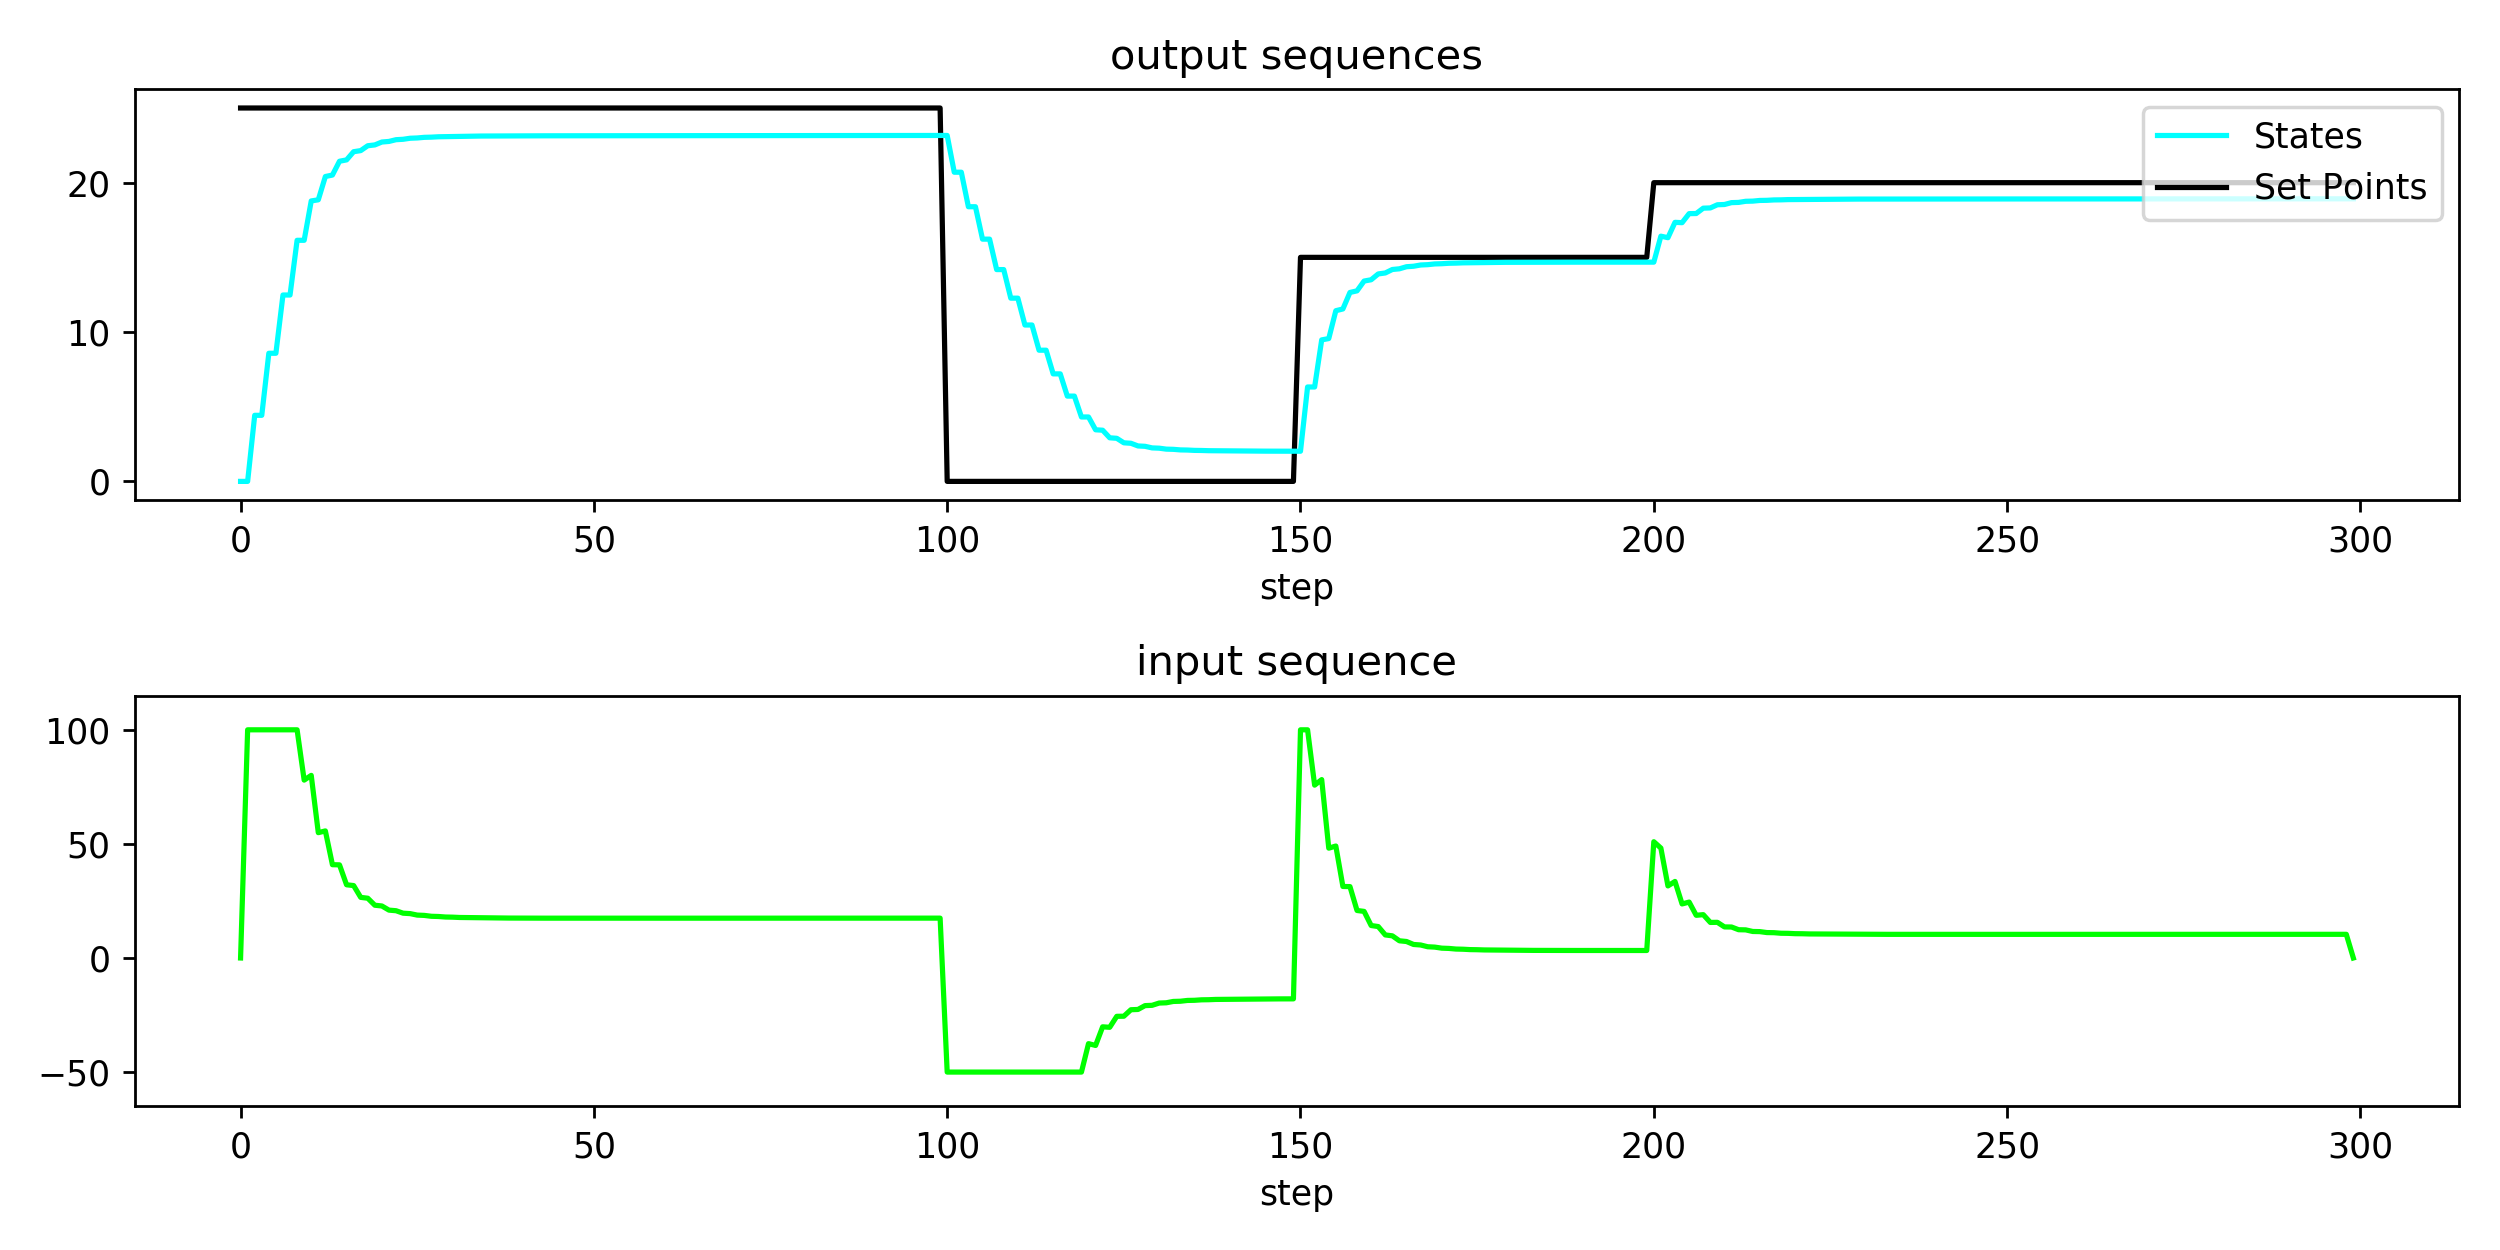

In [43]:
# use optimized weights to calculate response to set points trajectory
opt_PIDw = PIDw_hist[-1] 
# one output of optimization: [array(1.01742006), array(9.74795688), array(-0.00645071), array(1.11073878)], cost of 30.874

T = set_points.shape[1]

states = np.zeros(T)
actions = np.zeros(T)

dt = 1 # time is given in "steps"
    
Perror = 0
Ierror = 0
Derror = 0
last_error = 0
 
last_action = 0
last_state = 0

for ii in range(1,T-1):

    Perror = set_points[0,ii] - last_state
    Ierror = Ierror + (dt)*Perror
    Derror = (Perror - last_error) / dt

    actions[ii] = opt_PIDw[0] + opt_PIDw[1]*Perror + opt_PIDw[2]*Ierror + opt_PIDw[3]*Derror # current action from PID controller
    if (actions[ii]<-50.0):
        actions[ii]=-50.0
    if (actions[ii]>100.0):
        actions[ii]=100.0    
    states[ii+1] = V[0] + V[1]*last_state + V[2]*actions[ii] # current state from system model

    last_state = states[ii]
    last_action = actions[ii]
    last_error = Perror


# plot output of PID controller here
import matplotlib.pyplot as plt
from matplotlib import gridspec
import copy

# initialize figure
fig = plt.figure(figsize = (10,5))

# create subplot with 3 panels, plot input function in center plot
gs = gridspec.GridSpec(2,1) 
ax1 = plt.subplot(gs[1]); 
ax2 = plt.subplot(gs[0]);

ax1.plot(np.arange(np.size(actions)),actions.flatten(),c = 'lime',linewidth = 1.5)
ax2.plot(np.arange(np.size(states)),states.flatten(),c = 'cyan',linewidth = 1.5,label = 'States',zorder = 2)
ax2.plot(np.arange(np.size(set_points)),set_points.flatten(),c = 'k',linewidth = 1.5,label = 'Set Points',zorder = 1)

# label axes and title
ax1.set_title('input sequence')
ax1.set_xlabel('step')
ax2.set_title('output sequences')
ax2.set_xlabel('step')

# set viewing limits
s1min = np.min(copy.deepcopy(actions))
s1max = np.max(copy.deepcopy(actions))
s1gap = (s1max - s1min)*0.1
s1min -= s1gap
s1max += s1gap
ax1.set_ylim([s1min,s1max])

s2min = np.min(copy.deepcopy(states))
s2max = np.max(copy.deepcopy(states))
s2gap = (s2max - s2min)*0.1
s2min -= s2gap
s2max += s2gap
ax2.legend(loc = 1)

plt.show()

#### <span style="color:#a50e3e;">Exercise 3: </span>  System identification on the two-tank problem 

In this exercise you will create a system model - using a small snippet of cruise control data shown below.  This comes from a real life two-tanks experiment as shown on page 4 of the [course notes](https://www.dropbox.com/s/m6456ze0fd8kaf8/system_identification_pid_notes.pdf?dl=0).  The amount of water allowed into the top tank (per second) - the action sequence $a_t$ - is shown as the black curve in the bottom panel.  In the top panel the *upper* tank water level $s_{1,t}$ is shown in green, and the bottom tank level $s_{2,t}$ is shown in magenta.

<IPython.core.display.Javascript object>


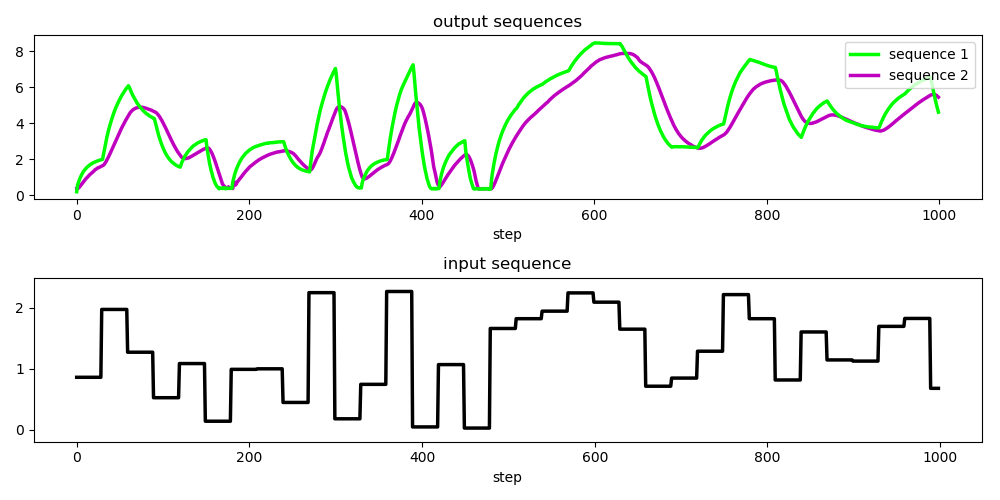

In [13]:
# This code cell will not be shown in the HTML version of this notebook
# load series
data = np.loadtxt(datapath + 'cascaded_tanks_1.csv',delimiter = ',')
actions = data[0:1,1:]
states = data[1:,:]

# plot the test pair
plotter.plot_3fer(actions,states[0],states[1],plot_type = 'continuous')

This system has two $s_{1,t}$ and $s_{2,t}$, hence the system model consists of an equation for each.  The upper tank level $s_{1,t}$ is dependent on its own history and - of course- the amount of water $a_t$ that is poured into it.  A simple linear system model for it then looks like

\begin{equation}
s_{1,t+1} = w_0 + w_1 s_{1,t} + w_2 a_t.
\end{equation}

Since we know that the upper tank drains into the lower one, the simplest sort of system model we can make for the lower tank level $s_{2,t}$ is that it is proportional to its prior value and that of the upper tank, as

\begin{equation}
s_{2,t+1} = w_3 + w_4s_{2,t} + w_5 s_{1,t}.
\end{equation}

Together - using the simplest model for this system we could think of - we have the following two system model equations

\begin{array}
\
s_{1,t+1} = w_0 + w_1 s_{1,t} + w_2 a_t \\
s_{2,t+1} = w_3 + w_4s_{2,t} + w_5 s_{1,t}.
\end{array}

Tune the parameters of this system model $w_0$ through $w_5$ via minimizing a Least Squares cost function, using the data shown above for training (i.e., you need not cut off a chunk of it for validation - use it all for training).  Make sure to plot the fit your model provides on the training data.  You can see this exact system model fit to this exact dataset in the course notes - make sure your fit looks fairly similar.

In [23]:
# least squares function

def g(w,a_train,s_train):
    ''' Least squares cost function'''
    
    J1 = 0
    J2 = 0
    T = s_train.shape[1]
    
    for ii in range(1,T-1):
        J1 = J1 + (w[0] + w[1]*s_train[0,ii] + w[2]*a_train[0,ii] - s_train[0,ii+1])**2 # cost for first tank
        J2 = J2 + (w[3] + w[4]*s_train[1,ii] + w[5]*s_train[0,ii] - s_train[1,ii+1])**2

    J = (J1+J2)/(T-1)

    return J

# gradient descent

weights = np.random.rand(6,1)

alpha = 0.025
max_its = 200
verbose = True

w_hist,train_hist = optimizers.gradient_descent(g,weights,actions,states,alpha,max_its,verbose)

print(w_hist[-1])

step 2 done in 1.3 secs, train cost = 1.2452
step 3 done in 1.3 secs, train cost = 1.119
step 4 done in 1.3 secs, train cost = 1.0634
step 5 done in 1.3 secs, train cost = 1.0135
step 6 done in 1.4 secs, train cost = 0.9662
step 7 done in 1.4 secs, train cost = 0.9213
step 8 done in 1.4 secs, train cost = 0.8787
step 9 done in 1.4 secs, train cost = 0.8383
step 10 done in 1.4 secs, train cost = 0.7999
step 11 done in 1.3 secs, train cost = 0.7634
step 12 done in 1.3 secs, train cost = 0.7288
step 13 done in 1.5 secs, train cost = 0.6958
step 14 done in 1.3 secs, train cost = 0.6645
step 15 done in 1.4 secs, train cost = 0.6348
step 16 done in 1.3 secs, train cost = 0.6066
step 17 done in 1.4 secs, train cost = 0.5797
step 18 done in 1.3 secs, train cost = 0.5542
step 19 done in 1.0 secs, train cost = 0.5299
step 20 done in 1.1 secs, train cost = 0.5068
step 21 done in 0.9 secs, train cost = 0.4848
step 22 done in 1.1 secs, train cost = 0.4639
step 23 done in 1.2 secs, train cost = 0.44

step 179 done in 1.3 secs, train cost = 0.009
step 180 done in 1.3 secs, train cost = 0.0089
step 181 done in 1.3 secs, train cost = 0.0088
step 182 done in 1.3 secs, train cost = 0.0087
step 183 done in 1.3 secs, train cost = 0.0086
step 184 done in 1.3 secs, train cost = 0.0085
step 185 done in 1.3 secs, train cost = 0.0085
step 186 done in 1.3 secs, train cost = 0.0084
step 187 done in 1.3 secs, train cost = 0.0083
step 188 done in 1.3 secs, train cost = 0.0082
step 189 done in 1.3 secs, train cost = 0.0081
step 190 done in 1.2 secs, train cost = 0.0081
step 191 done in 1.3 secs, train cost = 0.008
step 192 done in 1.3 secs, train cost = 0.0079
step 193 done in 1.5 secs, train cost = 0.0078
step 194 done in 1.4 secs, train cost = 0.0078
step 195 done in 1.4 secs, train cost = 0.0077
step 196 done in 1.3 secs, train cost = 0.0076
step 197 done in 1.3 secs, train cost = 0.0076
step 198 done in 1.3 secs, train cost = 0.0075
step 199 done in 1.3 secs, train cost = 0.0074
step 200 done i

<IPython.core.display.Javascript object>


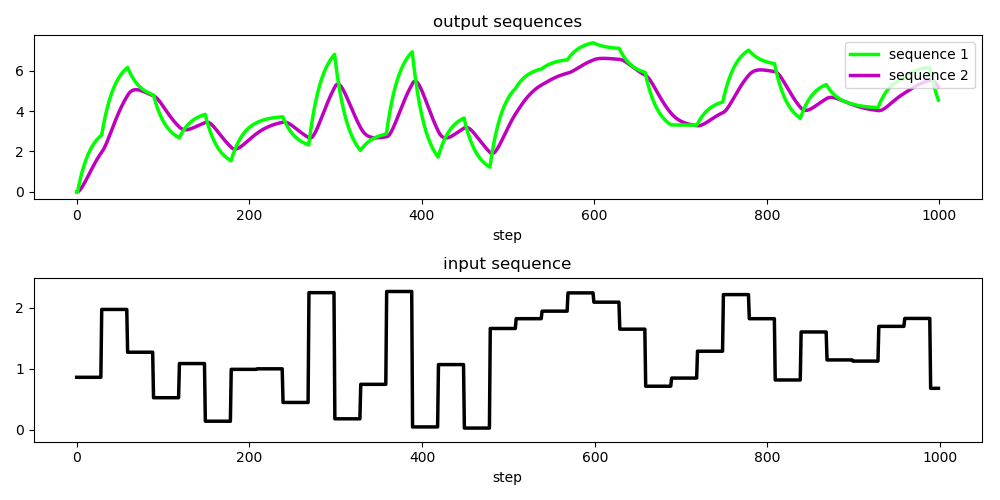

In [25]:
# use optimal weights to simulate system
# [0.04738977, 0.93622524, 0.19261502, 0.02357337, 0.92728438, 0.06336561], cost of 0.0073
opt_weights = w_hist[-1]

T = states.shape[1]
system_model = np.zeros(states.shape)

for ii in range(1,T-1):
    system_model[0,ii+1] = opt_weights[0] + opt_weights[1]*system_model[0,ii] + opt_weights[2]*actions[0,ii]
    system_model[1,ii+1] = opt_weights[3] + opt_weights[4]*system_model[1,ii] + opt_weights[5]*system_model[0,ii]
    
# plot results
plotter.plot_3fer(actions,system_model[0],system_model[1],plot_type = 'continuous')